In [ ]:
#default_exp bogacz

# Bogacz 2017

**Abstract**:

This paper provides an easy to follow tutorial on the free-energy framework for modelling perception
developed by Friston, which extends the predictive coding model of Rao and Ballard. These models assume
that the sensory cortex infers the most likely values of attributes or features of sensory stimuli from
the noisy inputs encoding the stimuli. Remarkably, these models describe how this inference could be
implemented in a network of very simple computational elements, suggesting that this inference could be
performed by biological networks of neurons. Furthermore, learning about the parameters describing the
features and their uncertainty is implemented in these models by simple rules of synaptic plasticity based
on Hebbian learning. This tutorial introduces the free-energy framework using very simple examples, and
provides step-by-step derivations of the model. It also discusses in more detail how the model could be
implemented in biological neural circuits. In particular, it presents an extended version of the model in
which the neurons only sum their inputs, and synaptic plasticity only depends on activity of pre-synaptic
and post-synaptic neurons.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
plt.style.use('seaborn')

## 2. Simplest Example of Perception


Consider a simple organism tries to infer size of food from ligh intensity
* Light intensity, $g(v)$, relates to surface area of food, $v$, according to $g(v) = v^2$
* Using light-receptors, organisms noisily estimates light intensity with mean $g(v)$ and variance $\Sigma_u$

The likelihood of the organism sensing a particular light intensity, $u$, given some food size $v$ is:
$$
p(u | v) = \text{Normal}(u; \text{mean}=g(v), \text{std dev}=\Sigma_u)
$$

The organism has some idea of reasonable food sizes, and it takes this prior knowledge into account when sensing the light; food can't be outrageously small or large, so any light detected probably comes from food that is around some average size $v_p$ with variance $\Sigma_p$ ("p" stands for "prior"):
$$
p(v) = \text{Normal}(v; v_p, \Sigma_p)
$$

But how does the organisms combine the likelihood and prior to best estimate the food size from light intensity?

### 2.1 Exact Solution

A while ago, some big-brain humans came up with a mathematically best way to combine prior and likelihood. This is **Baye's Theorem**:
$$
p(v | u) = \frac{p(u | v) p(v)}{p(u)}
$$

In words we have:
* Right hand side: The chance that the true food size is $v$ based on the estimated light intensity $u$
* Left hand side: the chance that this particular food size $v$ would produce that particular estimated light intensity $u$ AND the chance that the organism would even encounter food with size $v$, out of all the ways the organism could have estimated that particular light intensity $u$

#### Exercise 1

In [ ]:
#export

# --- Hypotheses
possible_food_sizes = np.linspace(0.01, 5.0, num=100)

# --- Priors
prior_food_size = dict(avg=3, variance=1) # v_p and Sigma_p
priors = stats.norm(prior_food_size['avg'], prior_food_size['variance']).pdf(possible_food_sizes)

# --- Data
estimated_light_intensity = 2 # u 
noisyness_of_estimate = 1 # Sigma_u

# --- Likelihoods
light_intensity_likelihood = stats.norm(estimated_light_intensity, noisyness_of_estimate)
# Remember that light_intensity(food_size) = food_size ** 2
possible_light_intensities = possible_food_sizes ** 2
likelihoods = light_intensity_likelihood.pdf(possible_light_intensities) # p(u | v)

# --- Posterior
probs_of_possible_food_sizes = likelihoods * priors / np.sum(likelihoods * priors) # p(v | u)
# Interval width helps us convert between probability and probability densities
hypothesis_interval_width = possible_food_sizes[1] - possible_food_sizes[0]
prob_densities_of_possible_food_sizes /= hypothesis_interval_width


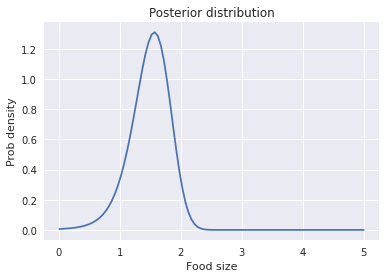

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(possible_food_sizes, probs_of_possible_food_sizes)
ax.set_xlabel('Food size')
ax.set_ylabel('Prob density')
ax.set_title('Posterior distribution')
plt.show()

### 2.2 Finding the most likely feature value

**REWRITE FOR BETTER EXPLANATION**

But this organism can't do fancy math like us. So how would a living thing with a nervous system combine the likelihood and prior in the best way possible?

Nervous systems are good at calculating rates of change, so it's plausible the nervous system to perform some kind of search algorithm to find the best value of $u$ that maximizes the posterior. We call this best value $\phi$

Specifically the nervous system minimizes some quantity $F$ which is the difference between some random guess posterior distribution and the true posterior distribution.

$$
\frac{\partial F}{\partial \phi} = \frac{v_p - \phi}{\Sigma_p} + \frac{u - g(\phi)}{\Sigma_u} g'(\phi)
$$

In our example, $g(v) = v^2$ so $g'(v) = 2v$

#### Exercise 2

In [ ]:
from typing import Callable
from collections import namedtuple

UpdateParams = namedtuple('UpdateParams', 'estimate, estimate_noise, prior, prior_noise')

def update(current_guess: float, up: UpdateParams, g: Callable, g_prime: Callable, delta_time: float):
    first_term = (up.prior - current_guess) / up.prior_noise
    second_term = ((up.estimate - g(current_guess)) / up.estimate_noise) * g_prime(current_guess)
    nudge_amnt = first_term + second_term # delta
    return current_guess + nudge_amnt * delta_time

def exercise2():
    prior_food_size = dict(avg=3, variance=1) # v_p and Sigma_p
    estimated_light_intensity = 2 # u 
    noisyness_of_estimate = 1 # Sigma_u
    up = UpdateParams(
        estimated_light_intensity,
        noisyness_of_estimate,
        prior_food_size['avg'],
        prior_food_size['variance'],
    )
    
    total_time = 5
    delta_time = 0.01
    time_series = np.linspace(0, total_time, num=int(int(total_time / delta_time)))
    guesses = np.zeros(len(time_series))
    initial_guess = prior_food_size['avg'] # phi
    guesses[0] = initial_guess
    
    g = lambda v: v*v
    g_prime = lambda v: 2*v
    
    for i, time in enumerate(time_series):
        if i == 0: continue
        guesses[i] = update(guesses[i-1], up, g, g_prime, delta_time)
    return time_series, guesses

time_series, guesses = exercise2()

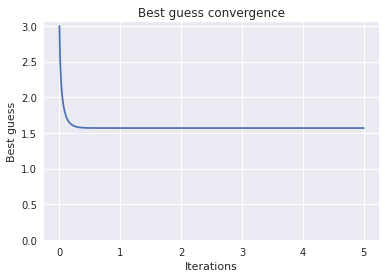

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(time_series, guesses)
ax.set_xlabel('Iterations')
ax.set_ylabel('Best guess')
ax.set_ylim(0.0, 3.05)
ax.set_title('Best guess convergence')
plt.show()